In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt langsmith langchain_ollama PyPDF2 requests

In [2]:
from langchain_ollama import ChatOllama
   
llm = ChatOllama(
    model="qwen2.5:7b",
    temperature=0,
)



c:\Users\Hrishi\miniconda3\envs\blueprint\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import requests
from typing import List, Dict, Any
import PyPDF2
import json
import re
from datetime import datetime

def extract_resume_pdf(file_path: str) -> Dict[str, Any]:
    """Extract information from a resume PDF file.
    
    Args:
        file_path: Path to the PDF resume file
        
    Returns:
        Dictionary containing extracted resume data (skills, experience, education, etc.)
    """
    try:
        with open(file_path, 'rb') as file:
            pdf_reader = PyPDF2.PdfReader(file)
            text = ""
            for page in pdf_reader.pages:
                text += page.extract_text()
        
        # Basic extraction logic
        resume_data = {
            "raw_text": text,
            "skills": extract_skills(text),
            "experience_years": extract_experience_years(text),
            "education": extract_education(text),
            "contact_info": extract_contact_info(text)
        }
        
        return resume_data
    except FileNotFoundError:
        return {"error": "File not found"}
    except Exception as e:
        return {"error": f"Error extracting resume: {str(e)}"}

def extract_skills(text: str) -> List[str]:
    """Extract skills from resume text."""
    # Common tech skills - expand as needed
    skill_keywords = [
        'python', 'java', 'javascript', 'react', 'node', 'sql', 'mongodb',
        'aws', 'docker', 'kubernetes', 'machine learning', 'data analysis',
        'project management', 'agile', 'scrum', 'leadership', 'communication',
        'typescript', 'angular', 'vue', 'c++', 'c#', 'ruby', 'php', 'swift',
        'kotlin', 'flutter', 'django', 'flask', 'spring', 'tensorflow', 'pytorch'
    ]
    
    text_lower = text.lower()
    found_skills = [skill for skill in skill_keywords if skill in text_lower]
    return found_skills

def extract_experience_years(text: str) -> int:
    """Extract years of experience from resume text."""
    # Look for patterns like "5 years of experience", "5+ years", etc.
    patterns = [
        r'(\d+)\+?\s*years?\s*of\s*experience',
        r'(\d+)\+?\s*years?\s*experience',
        r'experience\s*:\s*(\d+)\+?\s*years?'
    ]
    
    for pattern in patterns:
        match = re.search(pattern, text.lower())
        if match:
            return int(match.group(1))
    
    return 0

def extract_education(text: str) -> List[str]:
    """Extract education information from resume text."""
    education_keywords = ['bachelor', 'master', 'phd', 'mba', 'degree', 'university', 'college']
    education = []
    
    lines = text.split('\n')
    for line in lines:
        if any(keyword in line.lower() for keyword in education_keywords):
            education.append(line.strip())
    
    return education[:3]  # Return up to 3 education entries

def extract_contact_info(text: str) -> Dict[str, str]:
    """Extract contact information from resume text."""
    contact = {}
    
    # Email pattern
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    email_match = re.search(email_pattern, text)
    if email_match:
        contact['email'] = email_match.group(0)
    
    # Phone pattern
    phone_pattern = r'\b(?:\+?1[-.]?)?\(?([0-9]{3})\)?[-.]?([0-9]{3})[-.]?([0-9]{4})\b'
    phone_match = re.search(phone_pattern, text)
    if phone_match:
        contact['phone'] = phone_match.group(0)
    
    return contact

def search_jobs(query: str, location: str = "", num_results: int = 10) -> List[Dict[str, Any]]:
    """Search for jobs using a job search API.
    
    Args:
        query: Job title or keywords to search for
        location: Location to search in (city, state, or remote)
        num_results: Number of results to return (default 10)
        
    Returns:
        List of job postings with title, company, location, description, and link
    """
    try:
        # Using Adzuna API (free tier available)
        # You'll need to sign up at https://developer.adzuna.com/ for API keys
        app_id = "8835d454"  # Replace with actual API key
        app_key = "1b5f4297fcf0bd7bf42d898e8f14f421"  # Replace with actual API key
        
        base_url = "https://api.adzuna.com/v1/api/jobs/us/search/1"
        
        params = {
            "app_id": app_id,
            "app_key": app_key,
            "results_per_page": num_results,
            "what": query,
            "where": location,
            "content-type": "application/json"
        }
        
        response = requests.get(base_url, params=params, timeout=10)
        
        if response.status_code == 200:
            data = response.json()
            jobs = []
            
            for job in data.get('results', []):
                jobs.append({
                    "title": job.get('title', 'N/A'),
                    "company": job.get('company', {}).get('display_name', 'N/A'),
                    "location": job.get('location', {}).get('display_name', 'N/A'),
                    "description": job.get('description', 'N/A')[:500] + '...',  # Truncate
                    "salary_min": job.get('salary_min'),
                    "salary_max": job.get('salary_max'),
                    "link": job.get('redirect_url', 'N/A'),
                    "created": job.get('created', 'N/A')
                })
            
            return jobs
        else:
            return [{"error": f"API request failed with status code {response.status_code}"}]
            
    except requests.exceptions.Timeout:
        return [{"error": "Request timed out"}]
    except Exception as e:
        return [{"error": f"Error searching jobs: {str(e)}"}]

def filter_jobs_by_resume(jobs: List[Dict[str, Any]], resume_data: Dict[str, Any]) -> List[Dict[str, Any]]:
    """Filter and rank jobs based on resume match.
    
    Args:
        jobs: List of job postings
        resume_data: Extracted resume data
        
    Returns:
        Filtered and ranked list of jobs with match scores
    """
    try:
        if not jobs or not resume_data or "error" in resume_data:
            return jobs
        
        user_skills = set(skill.lower() for skill in resume_data.get('skills', []))
        
        scored_jobs = []
        for job in jobs:
            if 'error' in job:
                continue
                
            job_text = (job.get('title', '') + ' ' + job.get('description', '')).lower()
            
            # Calculate match score based on skills
            matching_skills = [skill for skill in user_skills if skill in job_text]
            match_score = len(matching_skills)
            
            job_with_score = job.copy()
            job_with_score['match_score'] = match_score
            job_with_score['matching_skills'] = matching_skills
            scored_jobs.append(job_with_score)
        
        # Sort by match score (descending)
        scored_jobs.sort(key=lambda x: x.get('match_score', 0), reverse=True)
        
        return scored_jobs
        
    except Exception as e:
        return [{"error": f"Error filtering jobs: {str(e)}"}]

def get_job_details(job_url: str) -> Dict[str, Any]:
    """Fetch detailed information about a specific job posting.
    
    Args:
        job_url: URL of the job posting
        
    Returns:
        Dictionary containing detailed job information
    """
    try:
        response = requests.get(job_url, timeout=10)
        
        if response.status_code == 200:
            return {
                "url": job_url,
                "status": "success",
                "message": "Job URL is accessible. User can click the link to view details."
            }
        else:
            return {
                "url": job_url,
                "status": "error",
                "message": f"Unable to access job posting (status code: {response.status_code})"
            }
            
    except Exception as e:
        return {
            "url": job_url,
            "status": "error",
            "message": f"Error accessing job: {str(e)}"
        }

# Update the tools list
tools_def = [extract_resume_pdf, search_jobs, filter_jobs_by_resume, get_job_details]

In [4]:
from langchain.agents import create_agent
from langgraph.checkpoint.memory import MemorySaver
agent = create_agent(llm, tools_def, checkpointer= MemorySaver())

In [5]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

system_prompt = """<role>
You are an AI job search assistant that helps users find relevant job opportunities based on their resume and preferences.
</role>

<capabilities>
You have access to the following tools:

1. extract_resume_pdf(file_path: str) -> Dict[str, Any]
   - Extracts information from a user's resume PDF
   - Returns skills, experience, education, and contact information
   - Use this when the user uploads a resume or mentions their resume file

2. search_jobs(query: str, location: str = "", num_results: int = 10) -> List[Dict[str, Any]]
   - Searches for job postings based on keywords and location
   - Returns list of jobs with title, company, location, description, salary info, and application links
   - Use this to find job opportunities matching user criteria

3. filter_jobs_by_resume(jobs: List[Dict[str, Any]], resume_data: Dict[str, Any]) -> List[Dict[str, Any]]
   - Filters and ranks jobs based on resume match
   - Calculates match scores based on skills overlap
   - Use this after getting both job results and resume data to find best matches

4. get_job_details(job_url: str) -> Dict[str, Any]
   - Fetches detailed information about a specific job posting
   - Verifies if job URL is accessible
   - Use this when user wants more details about a specific job
</capabilities>

<workflow>
When helping users with job search:

1. First, ask if they have a resume to upload or if they want to manually specify their skills and preferences
2. If they upload a resume, use extract_resume_pdf to analyze it
3. Ask about their job preferences (job title, location, experience level)
4. Use search_jobs to find relevant positions
5. If resume data is available, use filter_jobs_by_resume to rank jobs by match quality
6. Present the top matching jobs with details including:
   - Job title and company
   - Location
   - Brief description
   - Match score (if resume was analyzed)
   - Application link
7. Offer to search for more jobs, get details on specific postings, or refine the search
</workflow>

<guidelines>
- Be proactive in helping users understand their job market fit
- Explain why certain jobs are good matches based on their skills
- Provide actionable advice on applying to positions
- If the user hasn't uploaded a resume, you can still search jobs based on their stated preferences
- Always include application links so users can easily apply
- Be encouraging and supportive throughout the job search process
</guidelines>"""

# Node
def assistant(state: MessagesState):
   return {"messages": [llm.invoke([sys_msg] + state["messages"])]}

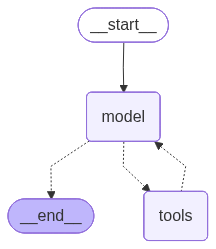

In [6]:
# from langgraph.graph import START, StateGraph
# from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

_____________________________________

In [7]:
config2 = {"configurable": {"thread_id": "2"}}

messages = [HumanMessage(content="show me the latest jobs for a data scientist")]
messages = agent.invoke({"messages": messages}, config2)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

show me the latest jobs for a data scientist
================================== Ai Message ==================================

Sure, I can help with that. Let's search for the latest job listings for a Data Scientist role.

I will use the `search_jobs` function to find relevant positions. Do you have a specific location in mind, or should we look for remote opportunities as well?
Tool Calls:
  search_jobs (0cb47648-9bb4-40b1-9a5f-003edc54d5dd)
 Call ID: 0cb47648-9bb4-40b1-9a5f-003edc54d5dd
  Args:
    location: 
    num_results: 10
    query: Data Scientist
================================= Tool Message =================================
Name: search_jobs

[{"title": "Senior Data Scientist", "company": "Disney Experiences", "location": "Celebration, Osceola County", "description": "A bout The Role & Team: At Disney Consumer Products , we inspire imagination around the world and are committed to creating ha

In [8]:
config2 = {"configurable": {"thread_id": "2"}}

messages = [HumanMessage(content="what are the skills required for a data scientist job")]
messages = agent.invoke({"messages": messages}, config2)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

show me the latest jobs for a data scientist
================================== Ai Message ==================================

Sure, I can help with that. Let's search for the latest job listings for a Data Scientist role.

I will use the `search_jobs` function to find relevant positions. Do you have a specific location in mind, or should we look for remote opportunities as well?
Tool Calls:
  search_jobs (0cb47648-9bb4-40b1-9a5f-003edc54d5dd)
 Call ID: 0cb47648-9bb4-40b1-9a5f-003edc54d5dd
  Args:
    location: 
    num_results: 10
    query: Data Scientist
================================= Tool Message =================================
Name: search_jobs

[{"title": "Senior Data Scientist", "company": "Disney Experiences", "location": "Celebration, Osceola County", "description": "A bout The Role & Team: At Disney Consumer Products , we inspire imagination around the world and are committed to creating ha

In [9]:
config1 = {"configurable": {"thread_id": "1"}}

messages = [HumanMessage(content="show me the latest jobs for a quantum computing scientist")]
messages = agent.invoke({"messages": messages}, config1)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

show me the latest jobs for a quantum computing scientist
================================== Ai Message ==================================

Sure, I can help with that. Let's search for the latest job listings for a quantum computing scientist.
Tool Calls:
  search_jobs (40b9f190-9b88-4740-9a57-df8880c08d33)
 Call ID: 40b9f190-9b88-4740-9a57-df8880c08d33
  Args:
    location: remote
    num_results: 10
    query: quantum computing scientist
================================= Tool Message =================================
Name: search_jobs

[]
================================== Ai Message ==================================

It seems like there was an issue fetching the job listings. Let me try again to ensure we get the latest jobs for a quantum computing scientist.
Tool Calls:
  search_jobs (3fd7eee5-647b-4422-8598-33bbbc4c6ba7)
 Call ID: 3fd7eee5-647b-4422-8598-33bbbc4c6ba7
  Args:
    location: remote
   

In [10]:
config3 = {"configurable": {"thread_id": "3"}}

messages = [HumanMessage(content="show me the latest jobs for a quantum computing scientist in India")]
messages = agent.invoke({"messages": messages}, config3)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

show me the latest jobs for a quantum computing scientist in India
================================== Ai Message ==================================
Tool Calls:
  search_jobs (7ffee914-ca4c-4646-8ab7-808f33d0d1f4)
 Call ID: 7ffee914-ca4c-4646-8ab7-808f33d0d1f4
  Args:
    location: India
    num_results: 10
    query: quantum computing scientist
================================= Tool Message =================================
Name: search_jobs

[]
================================== Ai Message ==================================
Tool Calls:
  search_jobs (519fb8ce-ab31-4161-8f15-285cd554664c)
 Call ID: 519fb8ce-ab31-4161-8f15-285cd554664c
  Args:
    location: India
    num_results: 10
    query: quantum computing scientist
  search_jobs (d40a49b8-2468-4341-b4fe-ea5d880b4c30)
 Call ID: d40a49b8-2468-4341-b4fe-ea5d880b4c30
  Args:
    location: India
    num_results: 10
    query: quantum computing scientist
=